In [ ]:
%reset -f

In [1]:
###############################
# IMPORTS
###############################

# torch things
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

import xarray as xr
# netCDF4 things
import netCDF4 as nc
from netCDF4 import Dataset as ncDataset

# normal python things
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import copy

from matplotlib.backends.backend_pdf import PdfPages


In [2]:
###############################
# CNN ARCHITECTURE
###############################

# Create simple CNN architecture
class CNN(nn.Module):
    def __init__(self, in_channels, out_features):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=4, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # same convolution, meaning that the output size will be the same dimensions as the input (294x294) here
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1)) # same convolution, meaning that the output size will be the same dimensions as the input (294x294) here
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(128*4*4, out_features) # size should be (out_channels from previous layer)*(input_size/2^num_layers) because the max pooling reduces dimension by 2 fold in each layer
        # self.softplus = nn.Softplus()  # Define Softplus as a layer

        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1) # flattens to be able to put into the fully-connected layer
        x = self.fc1(x)
        # x = torch.abs(x)  # Ensure no negative values in the output (do EITHER this or softplus, not both)
        # x = self.softplus(x) # Ensure no negative values in output (do EITHER this or abs, not both)

        return x
    
###############################
# SET GPU AND HYPERPARAMETERS
###############################

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
in_channels = 1
out_features = 1
#learning_rate = 0.001
#batch_size = 128
#num_epochs = 100
input_size = (1,294,294) #[C, H, W], the np arrays of images are [H, W], and the transform function converts to [H, W, C] 

# network structure
# in_channels = [

print("hyperparameters set")

###############################
# INITIALIZE NETWORK
###############################

# Initialize network
model = CNN(in_channels, out_features).to(device)

# Print the model summary
summary(model, input_size=input_size)

Using device: cuda
hyperparameters set
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 294, 294]              40
         MaxPool2d-2          [-1, 4, 147, 147]               0
            Conv2d-3          [-1, 8, 147, 147]             296
         MaxPool2d-4            [-1, 8, 73, 73]               0
            Conv2d-5           [-1, 16, 73, 73]           1,168
         MaxPool2d-6           [-1, 16, 36, 36]               0
            Conv2d-7           [-1, 32, 36, 36]           4,640
         MaxPool2d-8           [-1, 32, 18, 18]               0
            Conv2d-9           [-1, 64, 18, 18]          18,496
        MaxPool2d-10             [-1, 64, 9, 9]               0
           Conv2d-11            [-1, 128, 9, 9]          73,856
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                    [-1, 1]           2,049


In [3]:
###############################
# TRANSFORMATION DEFINITIONS
###############################

# define the desired transformations to the images and the labels (transform, transform_label)

# transform: transforms images from numpy array of shape [H, W] to tensors of shape [C, H, W] in range [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()  # Converts images to PyTorch tensors and scales to [0, 1]
])


# transform_label: transforms the labels to a more normal distribution
# def transform_label_function(label, facs=3):
#     # Ensure label is a tensor
#     label_tensor = torch.tensor(label, dtype=torch.float32)
#     # Apply the transformation
#     transformed_label = (torch.log10(label_tensor + 1 * 10 ** -facs) + facs) / (facs - 1)
#     return transformed_label
#fracture_density_min = xr.open_dataset('custom_nc_files/ncfile_south_large_example_train.nc')['fracture_density'].min()
#fracture_density_max = xr.open_dataset('custom_nc_files/ncfile_south_large_example_train.nc')['fracture_density'].max()
fracture_density_min = xr.open_dataset('data/data/custom_nc_files/ncfile_south_large_example_train.nc')['fracture_density'].min()
fracture_density_max = xr.open_dataset('data/data/custom_nc_files/ncfile_south_large_example_train.nc')['fracture_density'].max()
def transform_label_function(label):
    # Ensure label is a tensor
    label_tensor = torch.tensor(label, dtype=torch.float32)
    # Apply the transformation
    transformed_label = torch.tensor(((label_tensor-fracture_density_min) / (fracture_density_max-fracture_density_min)).values, dtype=torch.float32)
    return transformed_label


# inverse transform (to get back to original fracture density after the training)
# be careful to make sure this is the inverse function to the transform function (manual)
# def inverse_transform_label_function(transformed_label, facs=3):
#     inverse_transformed_label = 10**((facs-1)*transformed_label - facs) - 10**(-facs)
#     return inverse_transformed_label

def inverse_transform_label_function(transformed_function):
    inverse = []
    for x in transformed_function:
        inverse.append(x*((fracture_density_max-fracture_density_min)).values - fracture_density_min.values)
    print(len(transformed_function), len(inverse))
    return inverse



In [4]:
###############################
# DATASET CLASS CREATION FROM .nc FILES
###############################

# create custom dataset class from the .nc files
class NCDataset(Dataset):
    def __init__(self, nc_file_path, transform=None, transform_label=None):
        """
        Args:
            nc_file_path (string): Path to the .nc file
            transform (callable, optional): optional transform to apply to images
            transform_label (callable, optional): optional transform to apply to the labels
        """
        # load the .nc file
        self.nc_data = ncDataset(nc_file_path, 'r')
        
        # access the images (image_data) and labels (fracture_density) from the .nc file
        self.image_data = self.nc_data.variables['image_data']
        self.fracture_density = self.nc_data.variables['fracture_density']
        
        # image and label transforms (transform, transform_label)
        self.transform = transform
        self.transform_label = transform_label
        
        # load whole array into memory (could also convert to float32 here if that is not already done in preprocessing)
        self.image_data = self.image_data[:,:,:].astype(np.float32)
        self.fracture_density = self.fracture_density[:].astype(np.float32)
        
    def __len__(self):
        return self.image_data.shape[2]  # number of images is the third dimension [2]
        
    def __getitem__(self, idx):
        
        # Extract a single image and its corresponding label
        image = self.image_data[:, :, idx]
        label = self.fracture_density[idx]
        
        # Apply image transformation if any
        if self.transform:
            image = self.transform(image)
        
        # apply label transformation, if any
        if self.transform_label:
            label = self.transform_label(label)    
            
        # Convert to PyTorch tensors (might be repetitive)
        # image = torch.tensor(image, dtype=torch.float32)
        # label = torch.tensor(label, dtype=torch.float32)
        
        # return
        return image, label
        


In [24]:
###############################
# SET THE DATALOADERS
###############################

# .nc file path
#nc_file_path = 'custom_nc_files/ncfile_south_example_train.nc'
#nc_file_path_val = 'custom_nc_files/ncfile_south_outside_example_val.nc'
nc_file_path = 'data/data/custom_nc_files/ncfile_south_large_example_train.nc'
nc_file_path_val = 'data/data/custom_nc_files/ncfile_south_large_example_val.nc'
#nc_file_path_test = 'custom_nc_files/ncfile_north_outside.nc'
#nc_file_path_test = 'data/data/QB02_20120731155004.nc'
# load dataset from .nc file using NCDataset
# ds_train = NCDataset(nc_file_path, transform=transform, transform_label=lambda x: transform_label_function(x, facs=3))
# ds_val = NCDataset(nc_file_path_val, transform=transform, transform_label=lambda x: transform_label_function(x, facs=3))
ds_train = NCDataset(nc_file_path, transform=transform, transform_label=transform_label_function)
ds_val = NCDataset(nc_file_path_val, transform=transform, transform_label=transform_label_function)
#ds_test =  NCDataset(nc_file_path_test, transform=transform, transform_label=None)

# set the sampler based on samples <= 0.05 (or some other value)
weights = torch.ones(len(ds_train), dtype=torch.float)  # Start with all weights equal to 1
zero_label_weight = 0.2  # Weight for zero-labeled samples, adjust as needed
labels_train = np.array(nc.Dataset(nc_file_path, 'r').variables['fracture_density']).astype(np.float32) 
weights[labels_train == 0] = zero_label_weight  # Assign lower weight to zero-labeled samples
sampler = WeightedRandomSampler(weights=weights, num_samples=len(ds_train), replacement=True)

# dataloader (NOTE: only use either a sampler or shuffle, not both)
#dataloader_train = DataLoader(ds_train, batch_size=batch_size, sampler=None, shuffle=True, num_workers=4)
#dataloader_val = DataLoader(ds_val, batch_size=batch_size, sampler=None, num_workers=4)
#dataloader_test = DataLoader(ds_test, batch_size=batch_size, sampler=None, num_workers=4)

print(f'DataLoaders for train, val, and test sets have been set')

DataLoaders for train, val, and test sets have been set


In [6]:
dataset = xr.open_dataset(nc_file_path, chunks=None)
print(dataset["fracture_density"])

<xarray.DataArray 'fracture_density' (tiles: 16000)> Size: 128kB
[16000 values with dtype=float64]
Dimensions without coordinates: tiles
Attributes:
    Description:  Fraction of pixels in tile identified as a fracture


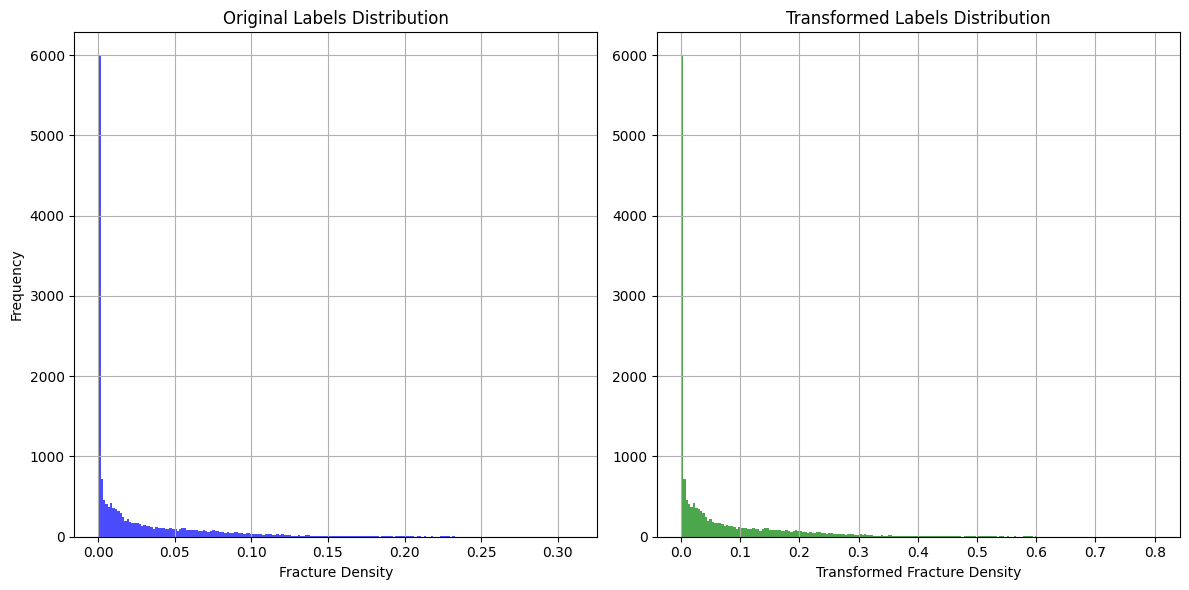

In [7]:

# extract original labels:
nc_data = ncDataset('custom_nc_files/ncfile_south_large_example_train.nc', 'r')
original_labels = nc_data.variables['fracture_density'][:].astype(np.float32)

# Compute transformed labels
transformed_labels = []
for label in original_labels:
    transformed_label = transform_label_function(label)
    transformed_labels.append(transformed_label)

# Convert list to numpy arrays
transformed_labels = np.array(transformed_labels)

# histogram plots
plt.figure(figsize=(12, 6))

# Histogram of original labels
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(original_labels, bins=200, alpha=0.7, color='blue')
plt.title('Original Labels Distribution')
plt.xlabel('Fracture Density')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram of transformed labels
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(transformed_labels, bins=200, alpha=0.7, color='green')
plt.title('Transformed Labels Distribution')
plt.xlabel('Transformed Fracture Density')
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
###############################
# LOSS, OPTIMIZER
###############################

# Define loss and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# print(f'loss criterion and optimizer have been set')

In [25]:
###############################
# TRAINING LOOP
###############################
def training_loop (num_epochs, batch_size, learning_rate):
    
    losses = []  # List to store loss values
    losses_train = []
    losses_val = []

    best_loss_val = float('inf')  # Initialize with a high value
    best_loss_train = float('inf')  # Initialize with a high value
    
    dataloader_train = DataLoader(ds_train, batch_size=batch_size, sampler=None, shuffle=True, num_workers=4)
    dataloader_val = DataLoader(ds_val, batch_size=batch_size, sampler=None, num_workers=4)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # beginning of training print statement:
    #print(f'train size[{len(ds_train)}]; val size[{len(ds_val)}]; batch size[{batch_size}]; batches per epoch[{len(dataloader_train)}]')

    #print(f'Starting new training loop (batch size[{batch_size}], learning rate[{learning_rate}], num_epochs[{num_epochs}]')
    # Now use the DataLoader in the training loop
    start_time_trainloop = time.time()
    
    best_loss_val_arr = []
    
    for epoch in range(num_epochs):
        # print(f"\r Starting epoch {epoch+1}")
        if epoch % 20 == 0 and epoch > 0:
            filepath = "model_weights_v3/best_model_wts_epoch" + str(epoch) + "_batch" +str(batch_size) + "_lr" + str(learning_rate)
            best_loss_val_arr.append(best_loss_val)
            
            # Optionally, save to a file
            torch.save(bestmodel_val_wts, filepath+'_wts_val.pt')
            
            
            # Optionally, save to a file
            torch.save(bestmodel_train_wts, filepath+'_wts_train.pt')

        # start epoch timer
        start_time_epoch = time.time() 

        for batch_idx, (images, labels) in enumerate(dataloader_train):
            # print(f"\r Processing batch {batch_idx+1}")

            # put data to cuda if possible
            images = images.to(device=device) # this moves the data tensor to the device which will carry out the computation
            labels = labels.to(device=device) # this moves the target tensor to the device which will carry out the computation

            # forward pass
            preds = torch.squeeze(model(images)) # this does the forward pass of the data through the model and computes the model predictions (aka 'scores') for each imput in the batch. scores represents the model prediction for the given input data
            # preds = torch.squeeze(preds)  # squeezes dimensions from [64, 1] to [64]. Now preds has shape [64], which is the same shape as the labels 
            loss = criterion(preds, labels) # this calculates the loss between the model prediction (scores) and the true label value (targets)
            # print(f'preds shape[{preds.shape}]')

            # backward pass
            optimizer.zero_grad() # sets all gradients to zero at the beginning of each batch, so doesn't store the backprop calculations from previous forward props
            loss.backward() # computes the gradients via backprop

            # gradient descent or adam step
            optimizer.step() # updates the weights depending on the gradients computed in loss.backward

            # Record the training loss for each iteration
            losses.append(loss.item())

        # record the training loss for each epoch
        losses_train.append(loss.item())

        # Validation phase (get validation loss and collect labels and predictions)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            for images, labels in dataloader_val:
                images = images.to(device=device)
                labels = labels.to(device=device)
                preds = torch.squeeze(model(images))
                loss_val = criterion(preds, labels)
        losses_val.append(loss_val.item())

        # save loss at the global minimum of the validation loss (loss_val)
        if loss_val < best_loss_val:
            # Update the best loss value
            best_loss_val = loss_val.item()
            # Save the best model parameters
            bestmodel_val_wts = copy.deepcopy(model.state_dict())

        # save loss at the global minimum of the training loss (loss_train)
        if loss < best_loss_train:
            # Update the best loss value
            best_loss_train = loss
            # Save the best model parameters
            bestmodel_train_wts = copy.deepcopy(model.state_dict())

        # end epoch timer
        end_time_epoch = time.time()
        epoch_duration = end_time_epoch - start_time_epoch
        elapsed_time_training = (end_time_epoch-start_time_trainloop)/60 #[minutes]

        # print end-of-epoch statement
        sys.stdout.write(f'\r epoch[{epoch+1}/{num_epochs}]; train loss[{loss.item():.8f}]; val loss[{loss_val.item():.8f}]; elapsed time[{elapsed_time_training:.4f} mins]')
        
        
    # Save the loss lists
    # Convert lists to tensors
    train_loss_tensor = torch.tensor(losses_train)
    val_loss_tensor = torch.tensor(losses_val)
    # Save tensors
    filepath_loss = "losses_v3/losses_batch" +str(batch_size) + "_lr" + str(learning_rate)+"losses.pt"
    torch.save({'train_loss': train_loss_tensor, 'val_loss': val_loss_tensor}, filepath_loss)
    
    # Optionally, save to a file
    filepath = "model_weights_v3/best_model_wts_epoch" + str(num_epochs) + "_batch" +str(batch_size) + "_lr" + str(learning_rate)
    torch.save(bestmodel_val_wts, filepath+'_wts_val.pt')


    # Optionally, save to a file
    torch.save(bestmodel_train_wts, filepath+'_wts_train.pt')
        
    return best_loss_val_arr
    
    # NOTE: 'targets' means the ground-truth labels, 'scores' or 'preds' are model predictions

In [26]:
###############################
# TUNE HYPERPARAMETERS
###############################

#num_epochs_choices = [20, 50, 100]
# batch_size_choices = [32, 64, 128, 256]
# learning_rate_choices = [0.01, 0.001, 0.0001]
# batch_size_choices = [256, 512, 1024]
# learning_rate_choices = [0.001, 0.0001]

batch_size_choices = [256]
learning_rate_choices = [0.001, 0.0005]

best_epoch = 100
best_batch = 0
best_lr = 0
best_loss = 1000


for batch_size in batch_size_choices:
    for learning_rate in learning_rate_choices:
        loss = training_loop(200, batch_size, learning_rate)
        for l in loss:
            if l < best_loss:
                best_batch_size = batch_size
                best_lr = learning_rate
                best_loss = l
                best_loss_arr = loss

        print()
        print(f' loss in epochs [{loss}] batch size [{batch_size}], learning rate [{learning_rate}]')
        print("\n")

#loss = training_loop(1000, 4096, 0.001)

 epoch[200/200]; train loss[0.00008368]; val loss[0.00821697]; elapsed time[42.0280 mins]
 loss in epochs [[0.005392856430262327, 0.005392856430262327, 0.005392856430262327, 0.005392856430262327, 0.005392856430262327, 0.005392856430262327, 0.005392856430262327, 0.005392856430262327, 0.005392856430262327]] batch size [256], learning rate [0.001]


 epoch[200/200]; train loss[0.00002233]; val loss[0.00800332]; elapsed time[41.8960 mins]
 loss in epochs [[0.008052135817706585, 0.00797002762556076, 0.007901626639068127, 0.007901626639068127, 0.007901626639068127, 0.007704092655330896, 0.007704092655330896, 0.007704092655330896, 0.007704092655330896]] batch size [256], learning rate [0.0005]




In [19]:
print(best_loss)
print(best_batch_size)
print(best_lr)
print(best_epoch)

0.0006202012300491333
512
0.001
0


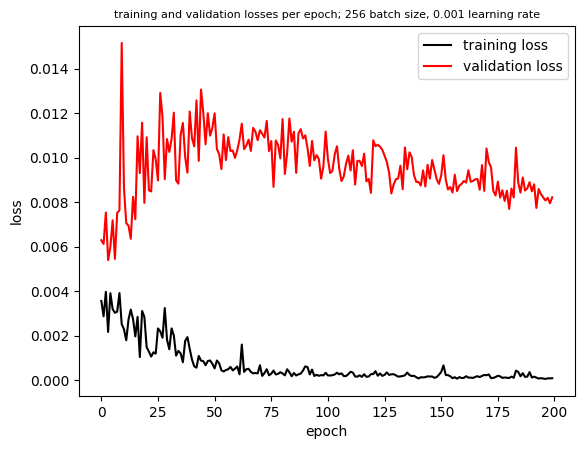

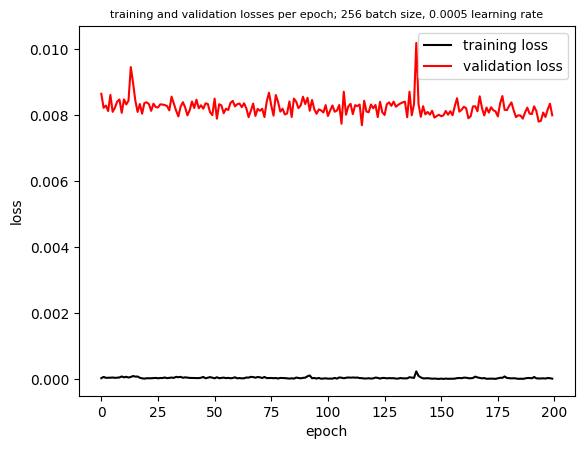

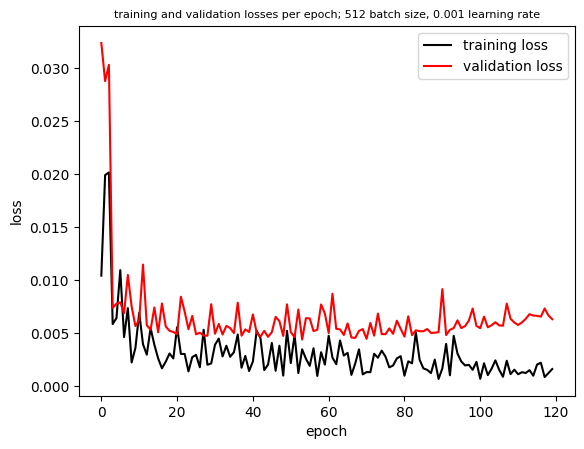

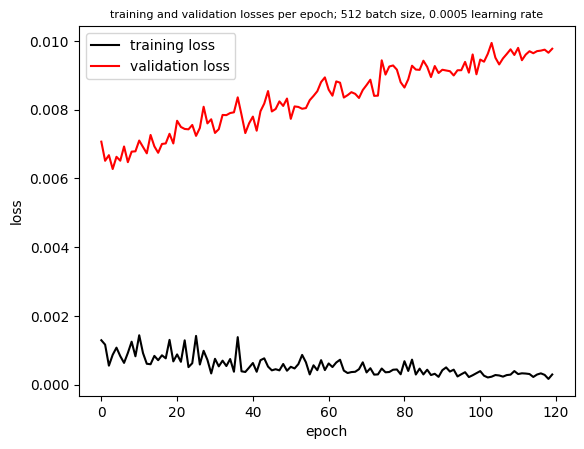

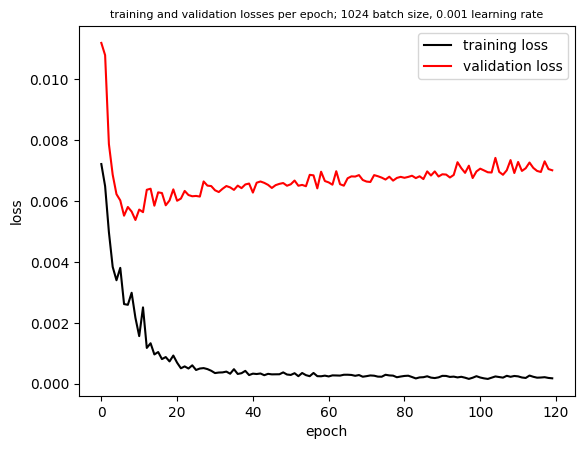

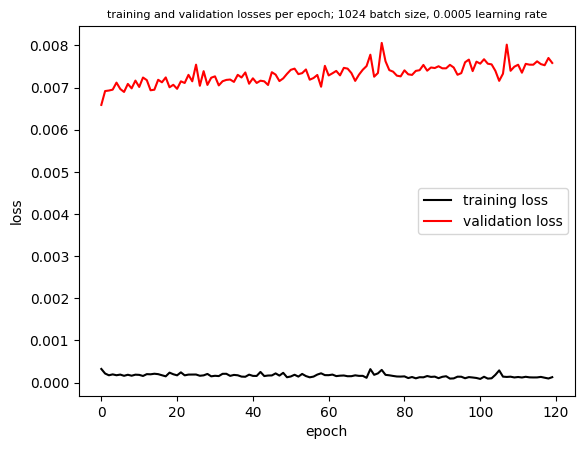

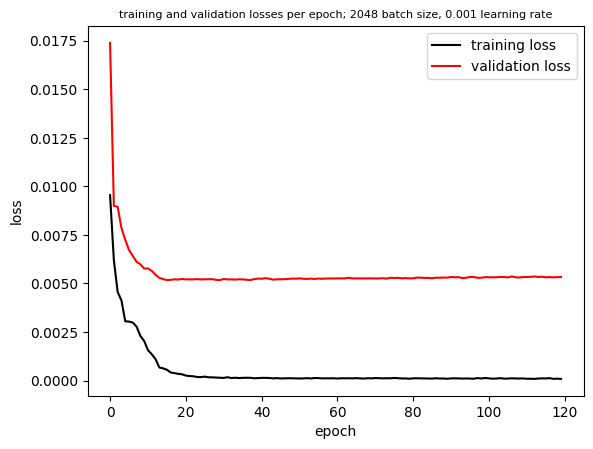

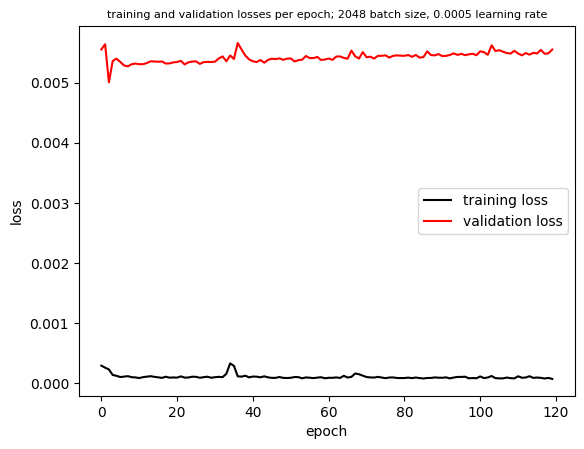

In [38]:
#num_epochs_choices = [20, 50, 100]
#batch_size_choices = [32, 64, 128, 256]
#batch_size_choices = [256, 512, 1024]
#learning_rate_choices = [0.001, 0.0001]
#learning_rate_choices = [0.01, 0.001, 0.0001]
# batch_size_choices = [512, 1024, 2048]
# learning_rate_choices = [0.001, 0.0005]
batch_size_choices = [256, 512, 1024, 2048]
learning_rate_choices = [0.001, 0.0005]

pdf = PdfPages('hyperparameter_tuning_10.pdf')
for batch_size in batch_size_choices:
    for learning_rate in learning_rate_choices:
        filepath_loss = "losses_v3/losses_batch" +str(batch_size) + "_lr" + str(learning_rate)+"losses.pt"
        loaded_losses = torch.load(filepath_loss)
        # Convert tensors to numpy arrays for plotting
        train_loss_array = loaded_losses['train_loss'].numpy()
        val_loss_array = loaded_losses['val_loss'].numpy()
        plt.figure()
        plt.plot(np.asarray(loaded_losses['train_loss']), c='black', label='training loss')
        plt.plot(np.asarray(loaded_losses['val_loss']), c='red', label='validation loss')
        plt.legend()
        plt.title(f'training and validation losses per epoch; {batch_size} batch size, {learning_rate} learning rate', fontsize = 8)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig(pdf, format='pdf')
pdf.close()

In [16]:
#FIND BEST LOSS
batch_size_choices = [256, 512, 1024]
learning_rate_choices = [0.001, 0.0005, 0.0001]
for batch_size in batch_size_choices:
    for learning_rate in learning_rate_choices:
        filepath_loss = "losses_v4/losses_batch" +str(batch_size) + "_lr" + str(learning_rate)+"losses.pt"
        loaded_losses = torch.load(filepath_loss)
        # Convert tensors to numpy arrays for plotting
        train_loss_array = loaded_losses['train_loss'].numpy()
        val_loss_array = loaded_losses['val_loss'].numpy()
        print(batch_size, learning_rate, val_loss_array[len(val_loss_array) - 1])

512 0.001 0.0063122595
512 0.0005 0.0097693335
1024 0.001 0.0070053963
1024 0.0005 0.007582631
2048 0.001 0.005331417
2048 0.0005 0.005549037
4096 0.001 0.004598983
4096 0.0005 0.003409167


In [17]:
batch_size_choices = [256, 512, 1024]
learning_rate_choices = [0.001, 0.0001]
for batch_size in batch_size_choices:
    for learning_rate in learning_rate_choices:
        filepath_loss = "losses_v2/losses_batch" +str(batch_size) + "_lr" + str(learning_rate)+"losses.pt"
        loaded_losses = torch.load(filepath_loss)
        # Convert tensors to numpy arrays for plotting
        train_loss_array = loaded_losses['train_loss'].numpy()
        val_loss_array = loaded_losses['val_loss'].numpy()
        print(batch_size, learning_rate, val_loss_array[len(val_loss_array) - 1])

256 0.001 0.0007968476
256 0.0001 0.0008593692
512 0.001 0.00070436264
512 0.0001 0.0007435613
1024 0.001 0.0004978305
1024 0.0001 0.0005210403


In [20]:
batch_size_choices = [32, 64, 128, 256]
learning_rate_choices = [0.01, 0.001, 0.0001]
for batch_size in batch_size_choices:
    for learning_rate in learning_rate_choices:
        filepath_loss = "losses/losses_batch" +str(batch_size) + "_lr" + str(learning_rate)+"losses.pt"
        loaded_losses = torch.load(filepath_loss)
        # Convert tensors to numpy arrays for plotting
        train_loss_array = loaded_losses['train_loss'].numpy()
        val_loss_array = loaded_losses['val_loss'].numpy()
        print(batch_size, learning_rate, val_loss_array[len(val_loss_array) - 1])

32 0.01 0.010602754
32 0.001 0.009198461
32 0.0001 0.009412586
64 0.01 0.008790715
64 0.001 0.008120875
64 0.0001 0.008361211
128 0.01 0.0044637253
128 0.001 0.0047570867
128 0.0001 0.0046137776
256 0.01 0.002946283
256 0.001 0.003143967
256 0.0001 0.0007629731


NameError: name 'ds_val_north' is not defined

In [20]:
epoch = 200
batch_size = 1024
learning_rate = 0.001


#ds_test = NCDataset(nc_file_path_test, transform=transform, transform_label=None)
#dataloader_test = DataLoader(ds_test, batch_size=batch_size, sampler=None, num_workers=4)


In [33]:
ds_train = NCDataset("data/data/custom_nc_files/ncfile_south_large_example_train.nc", transform=transform, transform_label=transform_label_function)
ds_val_south = NCDataset("data/data/custom_nc_files/ncfile_south_large_example_val.nc", transform=transform, transform_label= transform_label_function)
ds_val_north = NCDataset("/data/data/ncfile_north_outside_small_example.nc", transform=transform, transform_label=transform_label_function)
dataloader_val_south = DataLoader(ds_val_south, batch_size=batch_size, sampler=None, num_workers=4)
dataloader_val_north = DataLoader(ds_val_north, batch_size=batch_size, sampler=None, num_workers=4)
dataloader_train = DataLoader(ds_train, batch_size=batch_size, sampler=None, shuffle=True, num_workers=4)



In [34]:
print(fracture_density_min, fracture_density_max)

<xarray.DataArray 'fracture_density' ()> Size: 8B
array(0.) <xarray.DataArray 'fracture_density' ()> Size: 8B
array(0.31031052)


In [35]:
fracture_density_min = xr.open_dataset('data/data/custom_nc_files/ncfile_south_large_example_train.nc')['fracture_density'].min()
fracture_density_max = xr.open_dataset('data/data/custom_nc_files/ncfile_south_large_example_train.nc')['fracture_density'].max()
def transform_label_function(label):
    # Ensure label is a tensor
    label_tensor = torch.tensor(label, dtype=torch.float32)
    # Apply the transformation
    transformed_label = torch.tensor(((label_tensor-fracture_density_min) / (fracture_density_max-fracture_density_min)).values, dtype=torch.float32)
    return transformed_label

16000 16000
16000 16000
train set: predictions and labels acquired (16000)
4000 4000
4000 4000
4000 4000
4000 4000
validation set: predictions and labels acquired (4000)
batch_size 512, learning_rate 0.001, MSE_train 0.00024526974258954964, MSE_north 0.0012407192325057644, MSE_south 0.0002601231416051858


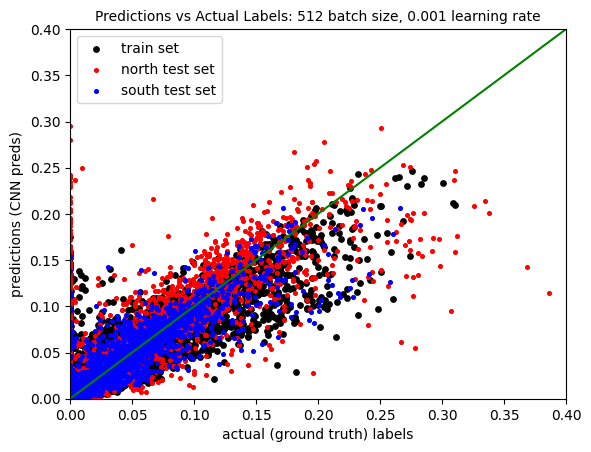

In [41]:
###
# CREATING FINAL GRAPHS
###
#epoch = 200
#batch_size = 512
#learning_rate = 0.001
#pdf = PdfPages('testing_v3.pdf')
epoch = 120
#batch_size_choices = [256, 512, 1024]
#learning_rate_choices = [0.001, 0.0001]
batch_size_choices = [256, 512, 1024, 2048]
learning_rate_choices = [0.001, 0.0005]
for batch_size in [512]:
    for learning_rate in [0.001]:
        filepath = "model_weights_v3/best_model_wts_epoch" + str(epoch) + "_batch" +str(batch_size) + "_lr" + str(learning_rate)+"_wts_val.pt"
        
        model = CNN(in_channels, out_features)
        model.load_state_dict(torch.load(filepath)) # load the model state from the desired output file (either best validation model or best training model)
        model.to(device) # send model to GPU
        model.eval()  # Evaluate model mode

        predictions_train = []
        actual_labels_train = []
        with torch.no_grad():
            for images, labels in dataloader_train:  # Assuming you want to do this for the training set
                images = images.to(device)
                preds = model(images)
                predictions_train.extend(preds.view(-1).tolist())  # Flatten and convert to list
                actual_labels_train.extend(labels.tolist())
        # Ensure predictions and actual_labels are numpy arrays for easier manipulation
        #predictions_train = inverse_transform_label_function(np.array(predictions_train))
        #actual_labels_train = inverse_transform_label_function(np.array(actual_labels_train))
        predictions_train = inverse_transform_label_function(np.array(predictions_train))
        actual_labels_train = inverse_transform_label_function(np.array(actual_labels_train))

        print(f"train set: predictions and labels acquired ({len(actual_labels_train)})")
        
        
        total = 0
        for i in range(len(predictions_train)):
            total += ((predictions_train[i] - actual_labels_train[i])**2)

        MSE_train = total/len(predictions_train)

        # validation set:
        predictions_val_north = []
        actual_labels_val_north = []
        with torch.no_grad():
            for images_val, labels_val in dataloader_val_north:  # Assuming you want to do this for the training set
                images_val = images_val.to(device)
                preds_val = model(images_val)
                predictions_val_north.extend(preds_val.view(-1).tolist())  # Flatten and convert to list
                actual_labels_val_north.extend(labels_val.tolist())
        # Ensure predictions and actual_labels are numpy arrays for easier manipulation
        #predictions_val_north = inverse_transform_label_function(np.array(predictions_val_north))
        #actual_labels_val_north = inverse_transform_label_function(np.array(actual_labels_val_north))
        predictions_val_north = inverse_transform_label_function(np.array(predictions_val_north))
        actual_labels_val_north = inverse_transform_label_function(np.array(actual_labels_val_north))
        
        total = 0
        for i in range(len(predictions_val_north)):
            total += ((predictions_val_north[i] - actual_labels_val_north[i])**2)

        MSE_north = total/len(predictions_val_north)
        predictions_val_south = []
        actual_labels_val_south = []
        with torch.no_grad():
            for images_val, labels_val in dataloader_val_south:  # Assuming you want to do this for the training set
                images_val = images_val.to(device)
                preds_val = model(images_val)
                predictions_val_south.extend(preds_val.view(-1).tolist())  # Flatten and convert to list
                actual_labels_val_south.extend(labels_val.tolist())
        # Ensure predictions and actual_labels are numpy arrays for easier manipulation
        #predictions_val_south = inverse_transform_label_function(np.array(predictions_val_south))
        #actual_labels_val_south = inverse_transform_label_function(np.array(actual_labels_val_south))
        predictions_val_south = inverse_transform_label_function(np.array(predictions_val_south))
        actual_labels_val_south = inverse_transform_label_function(np.array(actual_labels_val_south))
        
        total = 0
        for i in range(len(predictions_val_south)):
            total += ((predictions_val_south[i] - actual_labels_val_south[i])**2)

        MSE_south = total/len(predictions_val_south)

        print(f"validation set: predictions and labels acquired ({len(actual_labels_val_south)})")
        
        print(f"batch_size {batch_size}, learning_rate {learning_rate}, MSE_train {MSE_train}, MSE_north {MSE_north}, MSE_south {MSE_south}")

        plt.figure()
        plt.scatter(actual_labels_train, predictions_train, c='black', s=15, label='train set')
        plt.scatter(actual_labels_val_north, predictions_val_north, c='red', s=7, label='north test set')
        plt.scatter(actual_labels_val_south, predictions_val_south, c='blue', s=7, label='south test set')
        plt.plot(np.array(np.linspace(-2,2,11)),np.array(np.linspace(-2,2,11)),'g-')
        plt.title(f'Predictions vs Actual Labels: {batch_size} batch size, {learning_rate} learning rate', fontsize = 10)
        plt.xlabel('actual (ground truth) labels')
        plt.ylabel('predictions (CNN preds)')
        plt.xlim([0, 0.4])
        plt.ylim([0, 0.4])
        plt.legend()
        #plt.savefig(pdf, format='pdf')

#pdf.close()


NameError: name 'plt' is not defined

NameError: name 'num_epochs' is not defined